In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit
import pickle
2

# Ensure reproducibility'
np.random.seed(42)
tf.random.set_seed(42)
#tf.random.set_random_seed(42)

# Material constants
E = 193000e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
c1, c2, c3 = 230000e6, 19600e6, 1800e6  # Kinematic hardening constants
gamma1, gamma2, gamma3 = 1200, 140, 4  # Hardening constants
b = 8  # Isotropic hardening rate
Q = 110e6  # Isotropic hardening saturation value


# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history



# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return ((2.0 / 3.0) * c * eps_p_dot) - (gamma * sigma_k * np.abs(eps_p_dot))

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3                    
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 0, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial-E*delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)

    # Initialize state variables
    sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0

    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y
        )

        # Store the data
        back_stress = sigma_k1 + sigma_k2 + sigma_k3
        trial_phi=yield_function
        dataset.append([
            E, sigma_y, c1, gamma1, c2, gamma2, c3, gamma3, 
            b, Q, trial_phi, eps, sigma_updated, eps_p
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



2024-12-05 18:07:11.453370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 18:07:11.454084: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 18:07:11.456155: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 18:07:11.462653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 18:07:11.474747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [3]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [4]:
with open('scaler_X_abs.pkl', 'rb') as file:
    scaler_X = pickle.load(file)

with open('scaler_y_abs.pkl', 'rb') as file:
    scaler_y = pickle.load(file)

In [5]:
# Separate features and target
X = training[:, :-3]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training[:, -1]   # Targets (plastic_strain)

In [6]:
X_normalized = scaler_X.transform(X)

In [7]:
y = y.reshape(-1, 1)
y_normalized = scaler_y.transform(y)

In [8]:
model= tf.keras.models.load_model('plastic_strain_predictor_model_abs_05_12.h5')

In [9]:
y_pred_normalized = np.abs(model.predict(X_normalized))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step


In [10]:
y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()

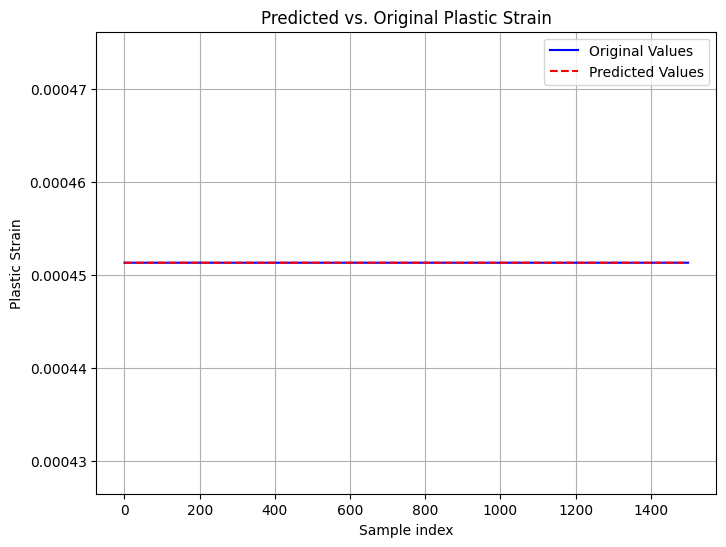

Plot saved as predicted_vs_actual


In [11]:
plot_predicted_vs_actual(y_pred_normalized, y_pred_normalized, filename='predicted_vs_actual.png')

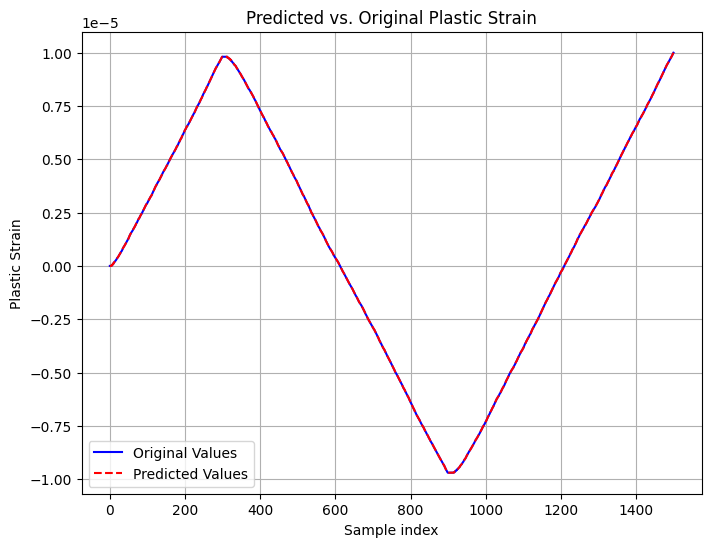

Plot saved as predicted_vs_actual


In [12]:
plot_predicted_vs_actual(y_normalized, y_normalized, filename='predicted_vs_actual.png')

In [14]:
y_pred_denormalized

array([1.9576458, 1.9576458, 1.9576458, ..., 1.9576458, 1.9576458,
       1.9576458], dtype=float32)